# Batch Normalization Keras
Normalize each batch by both mean and variance reference
### Purpose
As the data flows through a deep network, the weights and parameters adjust those values, sometimes making the data too big or too small again - a problem the authors refer to as "internal covariate shift". By normalizing the data in each mini-batch, this problem is largely avoided.

### Benefits:
- Networks train faster converge much more quickly,
- Allows higher learning rates Gradient descent usually requires small learning rates for the network to converge.
- Makes weights easier to initialize
- Makes more activation functions viable Because batch normalization regulates the values going into each activation function, non-linearlities that don't seem to work well in deep networks actually become viable again.
- May give better results overall  it's really an optimization to help train faster, so you shouldn't think of it as a way to make your network better.

### Keypoints
- Batch normalization uses weights as usual, but does NOT add a bias term. This is because, its calculations include gamma and beta variables that make the bias term unnecessary. In Keras `Dense(64, use_bias=False)` or `Conv2D(32, (3, 3), use_bias=False)`
- We add the normalization before calling the activation function.


In [1]:
from tensorflow.python import keras
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.python.keras.datasets import mnist
from tensorflow.python.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

keras.__version__

'2.0.8-tf'

In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)  # one-hot
test_labels = to_categorical(test_labels)

In [3]:
def data_generator(x, y, batch_size=32):
    batches = int(len(x)/batch_size)
    while 1:
        for i in range(batches):
            yield x[i*batch_size:(i+1)*batch_size], y[i*batch_size:(i+1)*batch_size]

In [7]:
img_size=(28, 28, 1)
class NeuralNet:
    def __init__(self, use_batch_norm, activation='relu'):
        self.use_batch_norm = use_batch_norm
        self.build_model(activation=activation)
    def add_dense_layer(self, units, activation='relu'):
        if self.use_batch_norm:
            self.model.add(layers.Dense(units, use_bias=False))
            self.model.add(layers.BatchNormalization())
            self.model.add(layers.Activation(activation))
        else:
            self.model.add(layers.Dense(units, activation=activation))
    def add_conv2d_layer(self, filters, kernel_size, activation='relu', **kwargs):
        if self.use_batch_norm:
            self.model.add(layers.Conv2D(filters, kernel_size, use_bias=False, **kwargs))
            self.model.add(layers.BatchNormalization())
            self.model.add(layers.Activation(activation))
        else:
            self.model.add(layers.Conv2D(filters, kernel_size, activation=activation, **kwargs))
    def build_model(self, activation):
        self.model = models.Sequential()
        self.add_conv2d_layer(32, (3, 3), activation=activation, input_shape=img_size)
        self.model.add(layers.MaxPooling2D((2, 2)))
        self.add_conv2d_layer(64, (3, 3), activation=activation)
        self.model.add(layers.MaxPooling2D((2, 2)))
        self.add_conv2d_layer(64, (3, 3), activation=activation)
        self.model.add(layers.Flatten())
        self.add_dense_layer(64, activation=activation)
        self.add_dense_layer(10, activation='softmax')
    def train(self, learning_rate=0.001, epoches=40, batch_size=32, steps_per_epoch=30):
        self.model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])
        history = self.model.fit_generator(generator=data_generator(train_images, train_labels, batch_size=batch_size),
                                      steps_per_epoch = steps_per_epoch,
                                      epochs = epoches,
                                      validation_data=data_generator(test_images, test_labels, batch_size=batch_size),
                                      validation_steps=len(test_images)/batch_size)
        return history.history

In [8]:
def plot_training_accuracies(*args, **kwargs):
    """
    Displays a plot of the accuracies calculated during training to demonstrate
    how many iterations it took for the model(s) to converge.
    
    :param args: One or more NeuralNet objects
        You can supply any number of NeuralNet objects as unnamed arguments 
        and this will display their training accuracies. Be sure to call `train` 
        the NeuralNets before calling this function.
    :param kwargs: 
        You can supply any named parameters here, but `steps_per_epoch` is the only
        one we look for. It should match the `steps_per_epoch` value you passed
        to the `train` function.
    """
    fig, ax = plt.subplots()

    steps_per_epoch = kwargs['steps_per_epoch']
    
    for history in args:
        ax.plot(range(0,len(history['acc'])*steps_per_epoch,steps_per_epoch),
                history['acc'], label="acc-" + history['name'])
        ax.plot(range(0,len(history['val_acc'])*steps_per_epoch,steps_per_epoch),
                history['val_acc'], label="val_acc-"+history['name'])
    ax.set_xlabel('Training steps')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy During Training')
    ax.legend(loc=4)
    #ax.set_ylim([0,1])
    #plt.yticks(np.arange(0, 1.1, 0.1))
    plt.grid(True)
    plt.show()

    
def train_and_test(learning_rate=0.001, activation="relu", epochs=40, steps_per_epoch=30):
    nn = NeuralNet(use_batch_norm=False, activation=activation)
    bn = NeuralNet(use_batch_norm=True, activation=activation)
    history_nn = nn.train(learning_rate=learning_rate, epoches=epochs, steps_per_epoch=steps_per_epoch)
    history_bn = bn.train(learning_rate=learning_rate, epoches=epochs, steps_per_epoch=steps_per_epoch)
    history_nn['name'] = "Without batch normalization"
    history_bn['name'] = "With batch normalization"
    plot_training_accuracies(history_nn, history_bn, steps_per_epoch=steps_per_epoch)

Epoch 1/3
1875/1875 [==============================] - 16s - loss: 0.1466 - acc: 0.9556 - val_loss: 0.0641 - val_acc: 0.9799
Epoch 2/3
1875/1875 [==============================] - 13s - loss: 0.0456 - acc: 0.9864 - val_loss: 0.0384 - val_acc: 0.9874
Epoch 3/3
1875/1875 [==============================] - 14s - loss: 0.0320 - acc: 0.9902 - val_loss: 0.0308 - val_acc: 0.9893
Epoch 1/3
1875/1875 [==============================] - 19s - loss: 0.2696 - acc: 0.9621 - val_loss: 0.0781 - val_acc: 0.9874
Epoch 2/3
1875/1875 [==============================] - 18s - loss: 0.0892 - acc: 0.9839 - val_loss: 0.0422 - val_acc: 0.9904
Epoch 3/3
1875/1875 [==============================] - 19s - loss: 0.0497 - acc: 0.9907 - val_loss: 0.0363 - val_acc: 0.9899


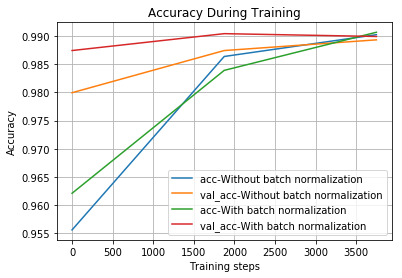

In [9]:
train_and_test(learning_rate=0.001, activation='relu', epochs=3, steps_per_epoch=1875)

Using a sigmoid activation function takes a long time to start learning. It eventually starts making progress, but it took over 250 batches just to get over 70% accuracy. Using batch normalization gets to 90% in around 100 batches.

Epoch 1/3
1875/1875 [==============================] - 14s - loss: 0.6409 - acc: 0.7923 - val_loss: 0.1481 - val_acc: 0.9563
Epoch 2/3
1875/1875 [==============================] - 14s - loss: 0.1160 - acc: 0.9659 - val_loss: 0.0870 - val_acc: 0.9737
Epoch 3/3
1875/1875 [==============================] - 13s - loss: 0.0753 - acc: 0.9772 - val_loss: 0.0812 - val_acc: 0.9755
Epoch 1/3
1875/1875 [==============================] - 19s - loss: 0.3273 - acc: 0.9506 - val_loss: 0.3006 - val_acc: 0.9298
Epoch 2/3
1875/1875 [==============================] - 18s - loss: 0.1341 - acc: 0.9731 - val_loss: 0.2695 - val_acc: 0.9211
Epoch 3/3
1875/1875 [==============================] - 19s - loss: 0.0864 - acc: 0.9813 - val_loss: 0.2049 - val_acc: 0.9364


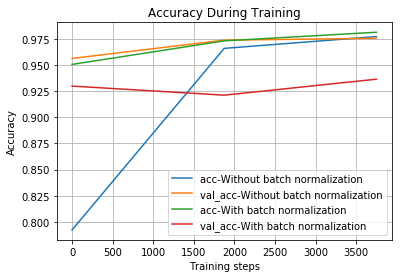

In [10]:
train_and_test(learning_rate=0.001, activation='sigmoid', epochs=3, steps_per_epoch=1875)

Epoch 1/3
1875/1875 [==============================] - 15s - loss: 0.1663 - acc: 0.9516 - val_loss: 0.1294 - val_acc: 0.9653
Epoch 2/3
1875/1875 [==============================] - 14s - loss: 0.1118 - acc: 0.9698 - val_loss: 0.1297 - val_acc: 0.9663
Epoch 3/3
1875/1875 [==============================] - 14s - loss: 0.1092 - acc: 0.9725 - val_loss: 0.1073 - val_acc: 0.9749
Epoch 1/3
1875/1875 [==============================] - 20s - loss: 0.1427 - acc: 0.9649 - val_loss: 0.0449 - val_acc: 0.9861
Epoch 2/3
1875/1875 [==============================] - 19s - loss: 0.0572 - acc: 0.9843 - val_loss: 0.0346 - val_acc: 0.9892
Epoch 3/3
1875/1875 [==============================] - 18s - loss: 0.0405 - acc: 0.9889 - val_loss: 0.0322 - val_acc: 0.9900


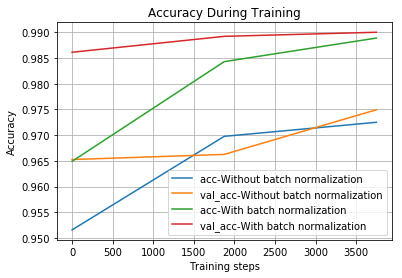

In [11]:
train_and_test(learning_rate=0.01, activation='relu', epochs=3, steps_per_epoch=1875)

Epoch 1/3
1875/1875 [==============================] - 15s - loss: 2.3207 - acc: 0.1000 - val_loss: 2.3055 - val_acc: 0.1136
Epoch 2/3
1875/1875 [==============================] - 13s - loss: 2.3196 - acc: 0.1006 - val_loss: 2.3056 - val_acc: 0.1138
Epoch 3/3
1875/1875 [==============================] - 14s - loss: 2.3196 - acc: 0.1007 - val_loss: 2.3056 - val_acc: 0.1135
Epoch 1/3
1875/1875 [==============================] - 19s - loss: 0.1780 - acc: 0.9555 - val_loss: 0.1830 - val_acc: 0.9371
Epoch 2/3
1875/1875 [==============================] - 19s - loss: 0.0698 - acc: 0.9802 - val_loss: 0.1817 - val_acc: 0.9388
Epoch 3/3
1875/1875 [==============================] - 19s - loss: 0.0471 - acc: 0.9865 - val_loss: 0.1507 - val_acc: 0.9513


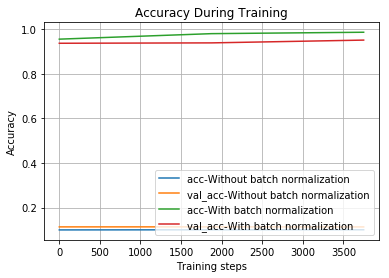

In [12]:
train_and_test(learning_rate=0.01, activation='sigmoid', epochs=3, steps_per_epoch=1875)

Epoch 1/3
1875/1875 [==============================] - 16s - loss: 2.3197 - acc: 0.1052 - val_loss: 2.3031 - val_acc: 0.1028
Epoch 2/3
1875/1875 [==============================] - 14s - loss: 2.3060 - acc: 0.1046 - val_loss: 2.3031 - val_acc: 0.1027
Epoch 3/3
1875/1875 [==============================] - 14s - loss: 2.3060 - acc: 0.1045 - val_loss: 2.3031 - val_acc: 0.1028
Epoch 1/3
1875/1875 [==============================] - 20s - loss: 0.1423 - acc: 0.9584 - val_loss: 0.0635 - val_acc: 0.9808
Epoch 2/3
1875/1875 [==============================] - 19s - loss: 0.0664 - acc: 0.9805 - val_loss: 0.0556 - val_acc: 0.9846
Epoch 3/3
1875/1875 [==============================] - 19s - loss: 0.0512 - acc: 0.9846 - val_loss: 0.0918 - val_acc: 0.9725


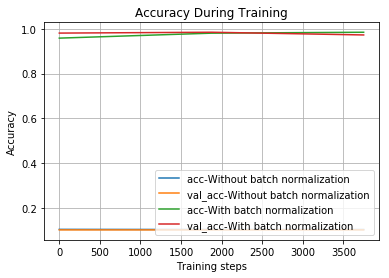

In [13]:
train_and_test(learning_rate=0.05, activation='relu', epochs=3, steps_per_epoch=1875)

Epoch 1/3
1875/1875 [==============================] - 16s - loss: 2.4200 - acc: 0.0968 - val_loss: 2.3309 - val_acc: 0.0957
Epoch 2/3
1875/1875 [==============================] - 15s - loss: 2.4183 - acc: 0.0970 - val_loss: 2.3311 - val_acc: 0.0958
Epoch 3/3
1875/1875 [==============================] - 14s - loss: 2.4183 - acc: 0.0970 - val_loss: 2.3312 - val_acc: 0.0956
Epoch 1/3
1875/1875 [==============================] - 21s - loss: 0.1550 - acc: 0.9546 - val_loss: 0.3872 - val_acc: 0.8604
Epoch 2/3
1875/1875 [==============================] - 18s - loss: 0.0713 - acc: 0.9784 - val_loss: 0.1212 - val_acc: 0.9615
Epoch 3/3
1875/1875 [==============================] - 19s - loss: 0.0562 - acc: 0.9834 - val_loss: 0.6120 - val_acc: 0.8367


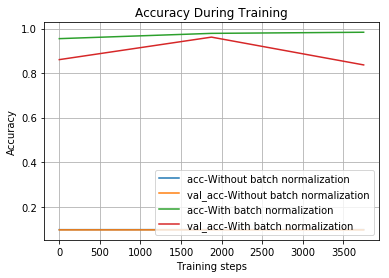

In [14]:
train_and_test(learning_rate=0.05, activation='sigmoid', epochs=3, steps_per_epoch=1875)

Try a smaller steps per epoch

Epoch 1/10
187/187 [==============================] - 3s - loss: 0.5941 - acc: 0.8234 - val_loss: 0.2623 - val_acc: 0.9182
Epoch 2/10
187/187 [==============================] - 2s - loss: 0.2010 - acc: 0.9408 - val_loss: 0.1624 - val_acc: 0.9502
Epoch 3/10
187/187 [==============================] - 2s - loss: 0.1423 - acc: 0.9552 - val_loss: 0.1097 - val_acc: 0.9645
Epoch 4/10
187/187 [==============================] - 2s - loss: 0.0973 - acc: 0.9711 - val_loss: 0.0728 - val_acc: 0.9782
Epoch 5/10
187/187 [==============================] - 2s - loss: 0.0883 - acc: 0.9721 - val_loss: 0.0773 - val_acc: 0.9757
Epoch 6/10
187/187 [==============================] - 2s - loss: 0.0845 - acc: 0.9749 - val_loss: 0.0581 - val_acc: 0.9824
Epoch 7/10
187/187 [==============================] - 2s - loss: 0.0771 - acc: 0.9766 - val_loss: 0.0577 - val_acc: 0.9804
Epoch 8/10
187/187 [==============================] - 2s - loss: 0.0825 - acc: 0.9741 - val_loss: 0.0535 - val_acc: 0.9832
Epoch 9/10
187/1

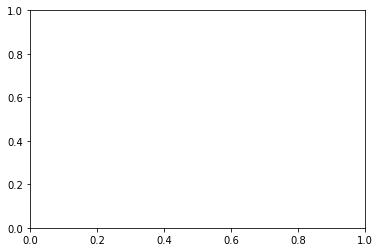

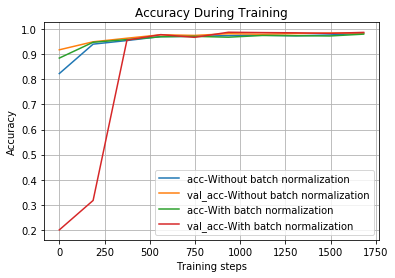

In [16]:
train_and_test(learning_rate=0.001, activation='relu', epochs=10, steps_per_epoch=int(1875/10))